# Primer modelo

In [270]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
Q0 = 240           # Producción inicial (millones de boe/año)
Qmax = 1500        # Producción máxima
t1 = 15            # Fin del crecimiento
t2 = t1 + 30       # Fin de la meseta
delta = 0.20       # Tasa de declino (20% anual)
dt = 1             # Paso de tiempo
S_total = 66000    # Total de reservas (millones de boe)

# Tiempo total simulado
t_final = 200
t = np.arange(0, t_final + dt, dt)


# Tasa de crecimiento lineal
g = (Qmax - Q0) / t1

# Función de producción por tramos
def production(ti):
    if ti < t1:
        return Q0 + g * ti
    elif ti < t2:
        return Qmax
    else:
        return Qmax * np.exp(-delta * (ti - t2))

# Producción y acumulación
Q_vals = np.array([production(ti) for ti in t])
cumulative = np.cumsum(Q_vals) * dt

# Encontrar cuándo se agotan las reservas
if np.any(cumulative >= S_total):
    t_exhaust_index = np.argmax(cumulative >= S_total)
    t_exhaust = t[t_exhaust_index]
    agotado = True
else:
    t_exhaust = None
    agotado = False

### Figura 1: Curva de extracción

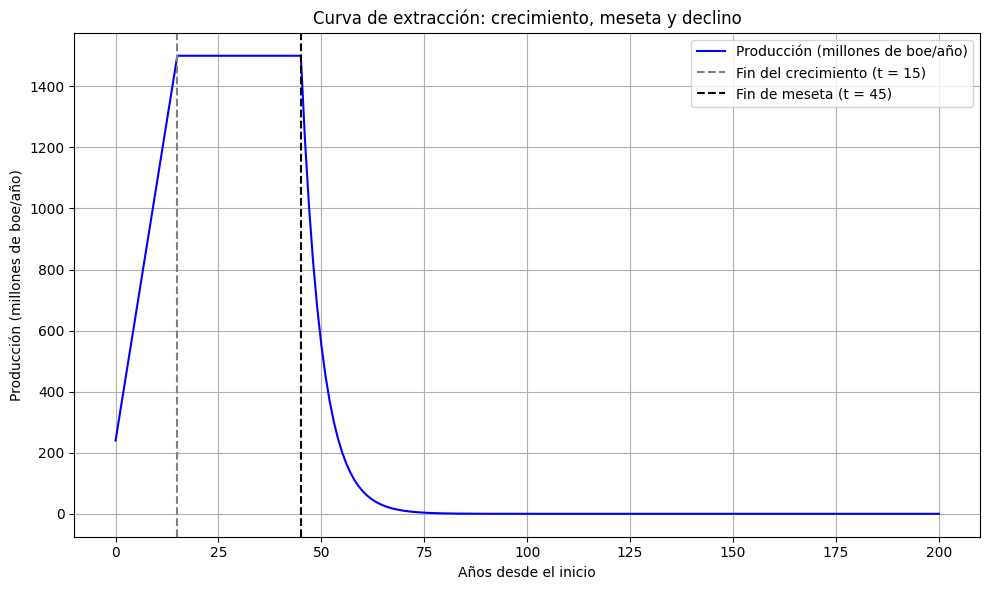

In [271]:
# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(t, Q_vals, label='Producción (millones de boe/año)', color='blue')
plt.axvline(x=t1, linestyle='--', color='gray', label='Fin del crecimiento (t = 15)')
plt.axvline(x=t2, linestyle='--', color='black', label='Fin de meseta (t = 45)')
if agotado:
    plt.axvline(x=t_exhaust, linestyle=':', color='red', label=f'Agotamiento (t ≈ {t_exhaust:.1f})')
plt.title("Curva de extracción: crecimiento, meseta y declino")
plt.xlabel("Años desde el inicio")
plt.ylabel("Producción (millones de boe/año)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

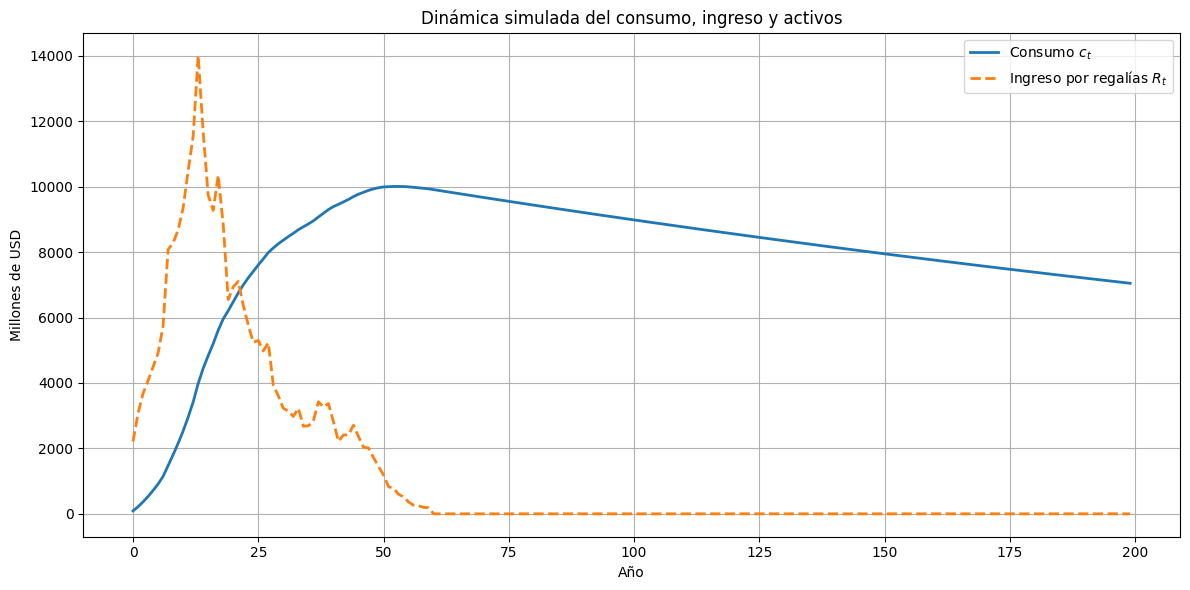

In [272]:
from scipy.interpolate import interp1d

# --------------------
# Parámetros del modelo
# --------------------
#np.random.seed(42)
beta = 0.961538461538462
r = 0.04
gamma = 2
tau = 0.15
P0 = 61.45
sigma_p = 0.1
T_sim = 200
q=Q_vals[0:T_sim] # Producción inicial (millones de boe/año)
years = np.arange(T_sim)

# --------------------
# Simulación de precios
# --------------------
log_prices = [np.log(P0)]
for _ in range(1, T_sim):
    log_prices.append(log_prices[-1] + np.random.normal(0, sigma_p))
P = np.exp(log_prices)

# --------------------
# Regalías
# --------------------
R = tau * q * P
# Corte exógeno de regalías en el año 30
R[60:] = 0

# --------------------
# Grilla de estados
# --------------------
x_min, x_max, Nx = 0.01, 1e4, 200
x_grid = np.linspace(x_min, x_max, Nx)
V = np.zeros(Nx)
V_new = np.zeros_like(V)
policy_c = np.zeros(Nx)
tolerance = 1e-5
max_iter = 500

# --------------------
# Iteración de la función de valor
# --------------------
V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')

for iteration in range(max_iter):
    for i, x in enumerate(x_grid):
        c_vals = np.linspace(0.001, x, 50)
        x_next_vals = (x - c_vals) * (1 + r)
        x_next_vals = np.clip(x_next_vals, x_min, x_max)
        V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')
        u_vals = np.log(c_vals) if gamma == 1 else (c_vals**(1 - gamma))/ (1 - gamma)
        total_vals = u_vals + beta * V_interp(x_next_vals)
        max_idx = np.argmax(total_vals)
        V_new[i] = total_vals[max_idx]
        policy_c[i] = c_vals[max_idx]
    if np.max(np.abs(V_new - V)) < tolerance:
        break
    V[:] = V_new

# --------------------
# Simulación hacia adelante con R_t
# --------------------
S = np.zeros(T_sim + 1)
X = np.zeros(T_sim)
c_sim = np.zeros(T_sim)

for t in range(T_sim):
    X[t] = S[t] + R[t]
    c_func = interp1d(x_grid, policy_c, kind='linear', fill_value='extrapolate')
    c_sim[t] = c_func(X[t])
    S[t + 1] = (X[t] - c_sim[t]) * (1 + r)

# --------------------
# Gráfico de resultados
# --------------------
plt.figure(figsize=(12, 6))
plt.plot(years, c_sim, label='Consumo $c_t$', lw=2)
#plt.plot(years, q, label='Recurso $Q_t$', lw=2)
plt.plot(years, R, label='Ingreso por regalías $R_t$', lw=2, linestyle='--')
#plt.plot(years, X, label='Cash-on-hand $X_t$', lw=2, linestyle=':')
#plt.plot(years, S[:-1], label='Activos $S_t$', lw=2, linestyle='-.')
plt.xlabel('Año')
plt.ylabel('Millones de USD')
plt.title('Dinámica simulada del consumo, ingreso y activos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


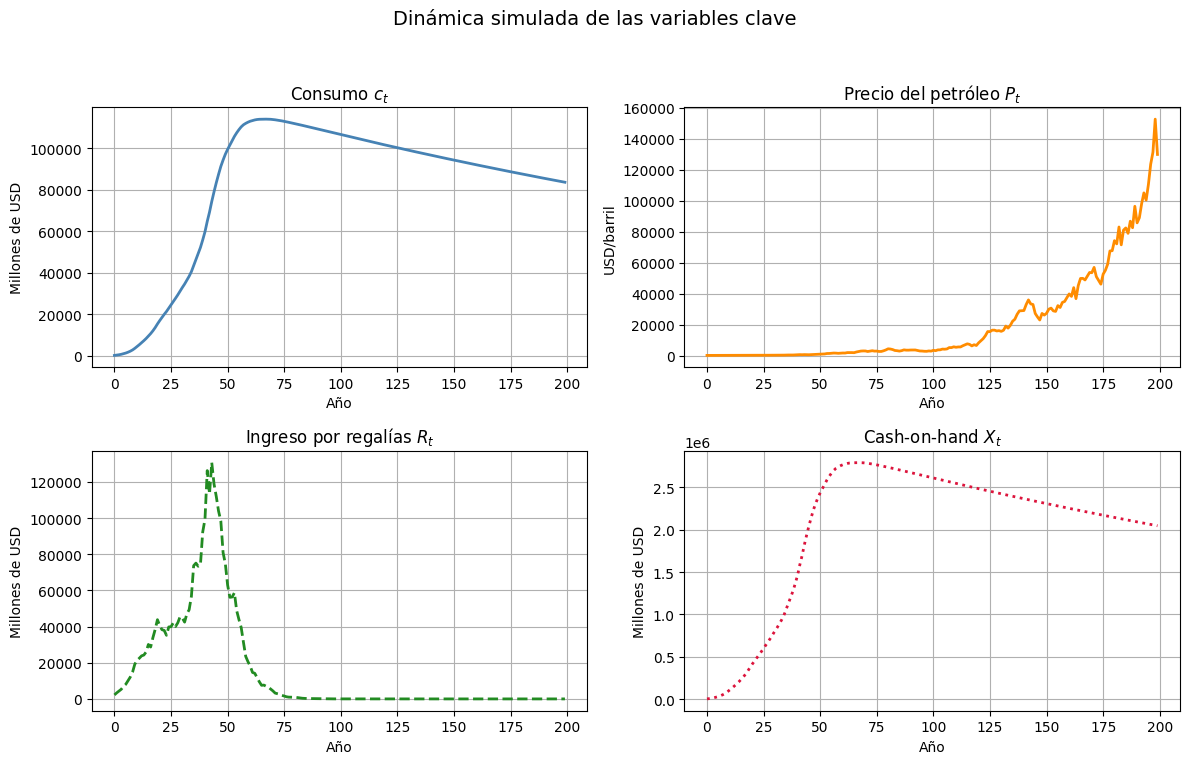

In [275]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumo
axs[0, 0].plot(years, c_sim, lw=2, color='steelblue')
axs[0, 0].set_title('Consumo $c_t$')
axs[0, 0].set_xlabel('Año')
axs[0, 0].set_ylabel('Millones de USD')
axs[0, 0].grid(True)

# Precio
axs[0, 1].plot(years, P, lw=2, color='darkorange')
axs[0, 1].set_title('Precio del petróleo $P_t$')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('USD/barril')
axs[0, 1].grid(True)

# Regalías
axs[1, 0].plot(years, R, lw=2, color='forestgreen', linestyle='--')
axs[1, 0].set_title('Ingreso por regalías $R_t$')
axs[1, 0].set_xlabel('Año')
axs[1, 0].set_ylabel('Millones de USD')
axs[1, 0].grid(True)

# Cash-on-hand
axs[1, 1].plot(years, X, lw=2, color='crimson', linestyle=':')
axs[1, 1].set_title('Cash-on-hand $X_t$')
axs[1, 1].set_xlabel('Año')
axs[1, 1].set_ylabel('Millones de USD')
axs[1, 1].grid(True)

plt.suptitle('Dinámica simulada de las variables clave', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Con Precios a la Hotelling

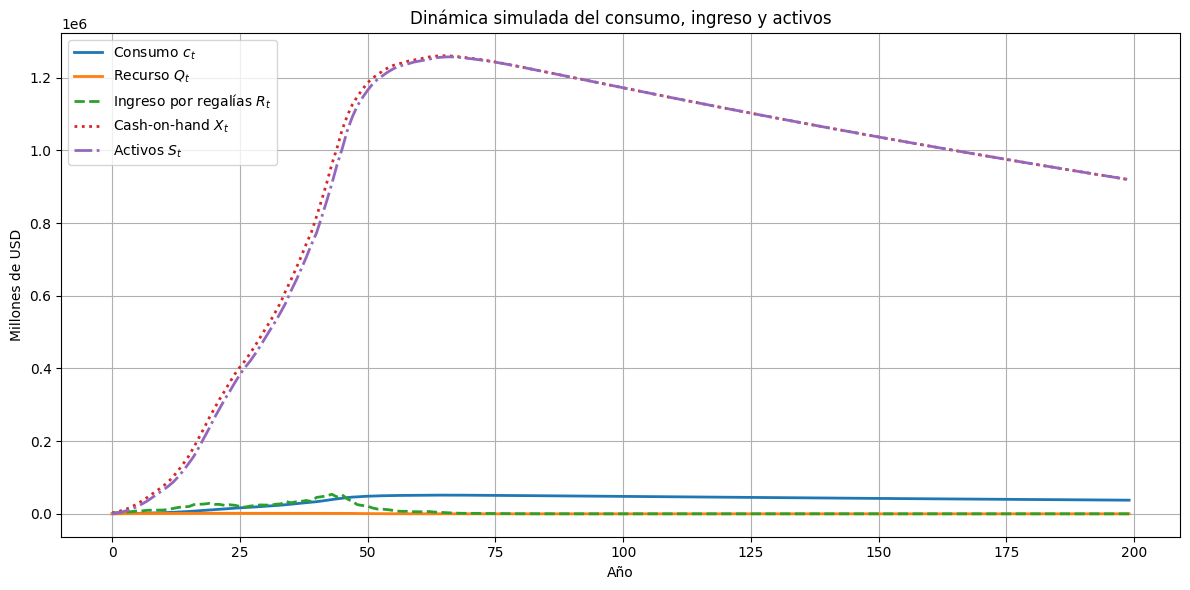

In [276]:
from scipy.interpolate import interp1d

# --------------------
# Parámetros del modelo
# --------------------
beta = 0.961538461538462
r = 0.04
gamma = 1
tau = 0.15
P0 = 61.45
sigma_p = 0.1
T_sim = 200
q=Q_vals[0:T_sim] # Producción inicial (millones de boe/año)
years = np.arange(T_sim)

# --------------------
# Simulación de precios
# --------------------
prices = [P0]
for _ in range(1, T_sim):
    prices.append(prices[-1]*(1+r) * (1 - np.random.normal(0, sigma_p)) )
P = np.array(prices)

# --------------------
# Curva de extracción tipo Hubbert


# --------------------
# Regalías
# --------------------
R = tau * q * P
# Corte exógeno de regalías en el año 30
#R[1:1000] = 100

# --------------------
# Grilla de estados
# --------------------
x_min, x_max, Nx = 0.01, 1e4, 200
x_grid = np.linspace(x_min, x_max, Nx)
V = np.zeros(Nx)
V_new = np.zeros_like(V)
policy_c = np.zeros(Nx)
tolerance = 1e-5
max_iter = 500

# --------------------
# Iteración de la función de valor
# --------------------
V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')

for iteration in range(max_iter):
    for i, x in enumerate(x_grid):
        c_vals = np.linspace(0.001, x, 50)
        x_next_vals = (x - c_vals) * (1 + r)
        x_next_vals = np.clip(x_next_vals, x_min, x_max)
        V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')
        u_vals = np.log(c_vals) if gamma == 1 else c_vals**(1 - gamma) / (1 - gamma)
        total_vals = u_vals + beta * V_interp(x_next_vals)
        max_idx = np.argmax(total_vals)
        V_new[i] = total_vals[max_idx]
        policy_c[i] = c_vals[max_idx]
    if np.max(np.abs(V_new - V)) < tolerance:
        break
    V[:] = V_new

# --------------------
# Simulación hacia adelante con R_t
# --------------------
S = np.zeros(T_sim + 1)
X = np.zeros(T_sim)
c_sim = np.zeros(T_sim)

for t in range(T_sim):
    X[t] = S[t] + R[t]
    c_func = interp1d(x_grid, policy_c, kind='linear', fill_value='extrapolate')
    c_sim[t] = c_func(X[t])
    S[t + 1] = (X[t] - c_sim[t]) * (1 + r)

# --------------------
# Gráfico de resultados
# --------------------
plt.figure(figsize=(12, 6))
plt.plot(years, c_sim, label='Consumo $c_t$', lw=2)
plt.plot(years, q, label='Recurso $Q_t$', lw=2)
plt.plot(years, R, label='Ingreso por regalías $R_t$', lw=2, linestyle='--')
plt.plot(years, X, label='Cash-on-hand $X_t$', lw=2, linestyle=':')
plt.plot(years, S[:-1], label='Activos $S_t$', lw=2, linestyle='-.')
plt.xlabel('Año')
plt.ylabel('Millones de USD')
plt.title('Dinámica simulada del consumo, ingreso y activos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




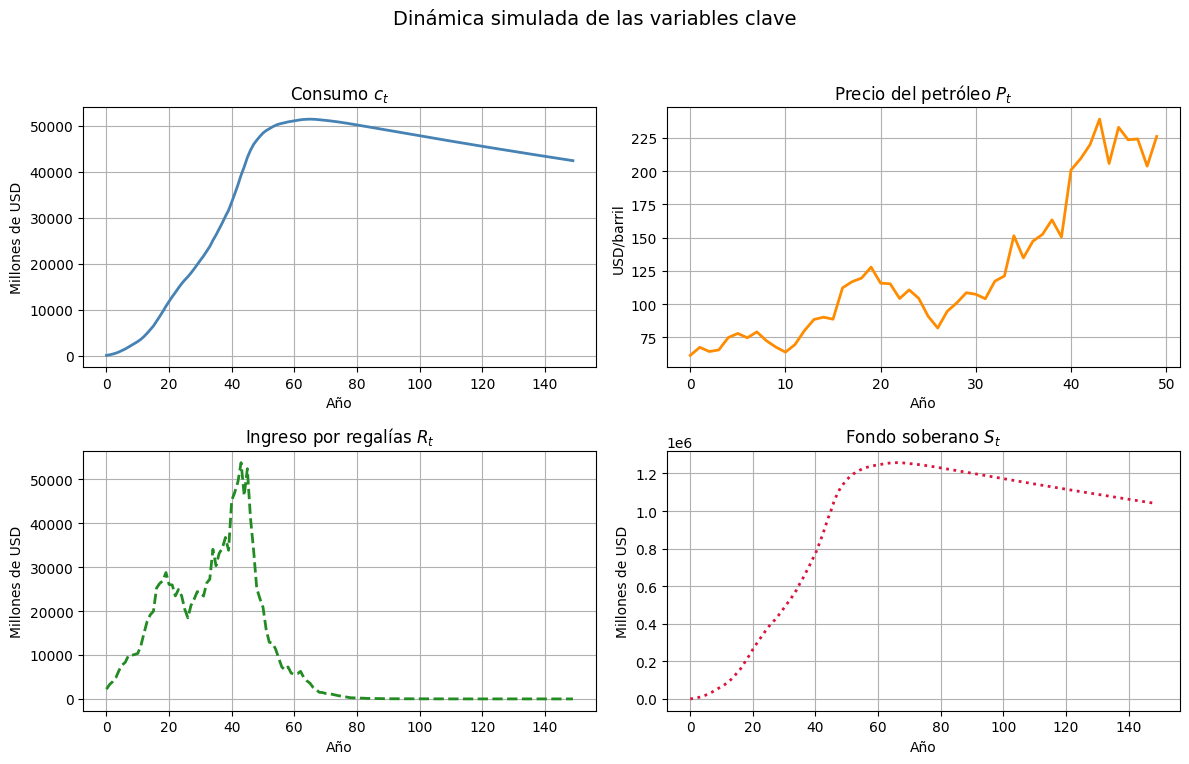

In [277]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
lapsus = 150
years = np.arange(lapsus)
# Consumo
axs[0, 0].plot(years, c_sim[0:lapsus], lw=2, color='steelblue')
axs[0, 0].set_title('Consumo $c_t$')
axs[0, 0].set_xlabel('Año')
axs[0, 0].set_ylabel('Millones de USD')
axs[0, 0].grid(True)

# Precio
axs[0, 1].plot(years[:50], P[0:50], lw=2, color='darkorange')
axs[0, 1].set_title('Precio del petróleo $P_t$')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('USD/barril')
axs[0, 1].grid(True)

# Regalías
axs[1, 0].plot(years, R[0:lapsus], lw=2, color='forestgreen', linestyle='--')
axs[1, 0].set_title('Ingreso por regalías $R_t$')
axs[1, 0].set_xlabel('Año')
axs[1, 0].set_ylabel('Millones de USD')
axs[1, 0].grid(True)

# Cash-on-hand
axs[1, 1].plot(years, S[0:lapsus], lw=2, color='crimson', linestyle=':')
axs[1, 1].set_title('Fondo soberano $S_t$')
axs[1, 1].set_xlabel('Año')
axs[1, 1].set_ylabel('Millones de USD')
axs[1, 1].grid(True)

plt.suptitle('Dinámica simulada de las variables clave', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Precios con reversión a la media y velocidad ponderada por tasa de interés.

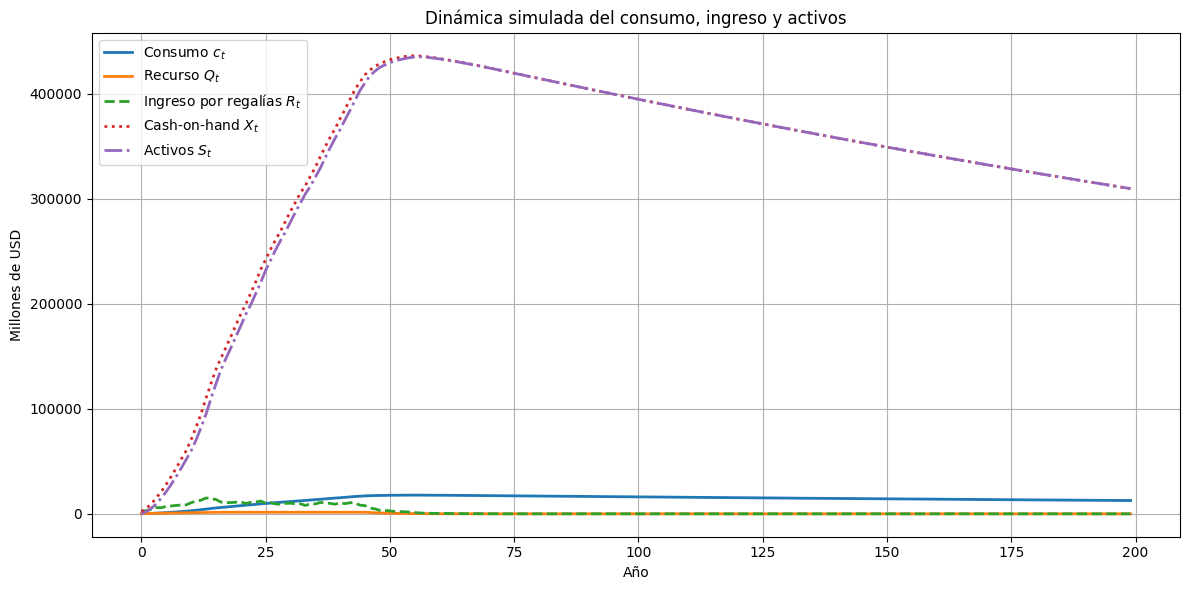

In [285]:
from scipy.interpolate import interp1d

# --------------------
# Parámetros del modelo
# --------------------
beta = 0.961538461538462
r = 0.04
gamma = 1
tau = 0.15
P0 = 61.45
sigma_p = 5
T_sim = 200
q=Q_vals[0:T_sim] # Producción inicial (millones de boe/año)
years = np.arange(T_sim)

# --------------------
# Simulación de precios
# --------------------

kappa = r / (1 + r)
P = [P0]
P_bar = P0

for t in range(1, T_sim):
    #P_bar.append(P_bar[-1])
    P_next = P[-1] + kappa * (P_bar - P[-1]) +  np.random.normal(0, sigma_p)
    P.append(P_next)


# --------------------
# Regalías
# --------------------
R = tau * q * P
# Corte exógeno de regalías en el año 30
#R[1:1000] = 100

# --------------------
# Grilla de estados
# --------------------
x_min, x_max, Nx = 0.01, 1e4, 200
x_grid = np.linspace(x_min, x_max, Nx)
V = np.zeros(Nx)
V_new = np.zeros_like(V)
policy_c = np.zeros(Nx)
tolerance = 1e-5
max_iter = 500

# --------------------
# Iteración de la función de valor
# --------------------
V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')

for iteration in range(max_iter):
    for i, x in enumerate(x_grid):
        c_vals = np.linspace(0.001, x, 50)
        x_next_vals = (x - c_vals) * (1 + r)
        x_next_vals = np.clip(x_next_vals, x_min, x_max)
        V_interp = interp1d(x_grid, V, kind='linear', fill_value='extrapolate')
        u_vals = np.log(c_vals) if gamma == 1 else c_vals**(1 - gamma) / (1 - gamma)
        total_vals = u_vals + beta * V_interp(x_next_vals)
        max_idx = np.argmax(total_vals)
        V_new[i] = total_vals[max_idx]
        policy_c[i] = c_vals[max_idx]
    if np.max(np.abs(V_new - V)) < tolerance:
        break
    V[:] = V_new

# --------------------
# Simulación hacia adelante con R_t
# --------------------
S = np.zeros(T_sim + 1)
X = np.zeros(T_sim)
c_sim = np.zeros(T_sim)

for t in range(T_sim):
    X[t] = S[t] + R[t]
    c_func = interp1d(x_grid, policy_c, kind='linear', fill_value='extrapolate')
    c_sim[t] = c_func(X[t])
    S[t + 1] = (X[t] - c_sim[t]) * (1 + r)

# --------------------
# Gráfico de resultados
# --------------------
plt.figure(figsize=(12, 6))
plt.plot(years, c_sim, label='Consumo $c_t$', lw=2)
plt.plot(years, q, label='Recurso $Q_t$', lw=2)
plt.plot(years, R, label='Ingreso por regalías $R_t$', lw=2, linestyle='--')
plt.plot(years, X, label='Cash-on-hand $X_t$', lw=2, linestyle=':')
plt.plot(years, S[:-1], label='Activos $S_t$', lw=2, linestyle='-.')
plt.xlabel('Año')
plt.ylabel('Millones de USD')
plt.title('Dinámica simulada del consumo, ingreso y activos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




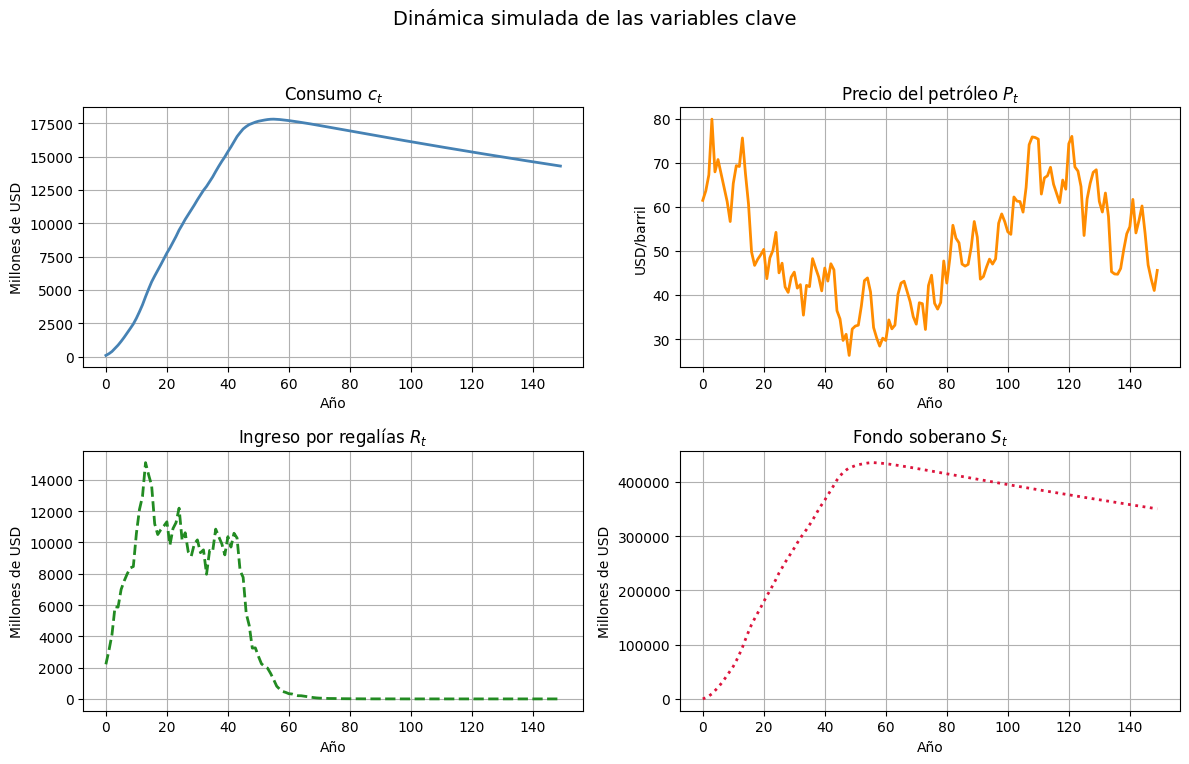

In [286]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
lapsus = 150
years = np.arange(lapsus)
# Consumo
axs[0, 0].plot(years, c_sim[0:lapsus], lw=2, color='steelblue')
axs[0, 0].set_title('Consumo $c_t$')
axs[0, 0].set_xlabel('Año')
axs[0, 0].set_ylabel('Millones de USD')
axs[0, 0].grid(True)

# Precio
axs[0, 1].plot(years[:lapsus], P[0:lapsus], lw=2, color='darkorange')
axs[0, 1].set_title('Precio del petróleo $P_t$')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('USD/barril')
axs[0, 1].grid(True)

# Regalías
axs[1, 0].plot(years, R[0:lapsus], lw=2, color='forestgreen', linestyle='--')
axs[1, 0].set_title('Ingreso por regalías $R_t$')
axs[1, 0].set_xlabel('Año')
axs[1, 0].set_ylabel('Millones de USD')
axs[1, 0].grid(True)

# Cash-on-hand
axs[1, 1].plot(years, S[0:lapsus], lw=2, color='crimson', linestyle=':')
axs[1, 1].set_title('Fondo soberano $S_t$')
axs[1, 1].set_xlabel('Año')
axs[1, 1].set_ylabel('Millones de USD')
axs[1, 1].grid(True)

plt.suptitle('Dinámica simulada de las variables clave', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [282]:
P

[61.45,
 61.587846962746156,
 61.59412761520938,
 61.62754469780283,
 61.39867395468614,
 61.28085139043033,
 61.37606508382764,
 61.40758614568791,
 61.39449691990827,
 61.45311588961796,
 61.61657582832316,
 61.58806481934164,
 61.58969161424815,
 61.603578551727125,
 61.8368826478804,
 61.61206691959694,
 61.6741558780144,
 61.65405427321487,
 61.702883204555796,
 61.627419672058025,
 61.615699335431486,
 61.680467342015284,
 61.982894233580616,
 62.043201920460035,
 61.93557990217776,
 61.87452778389173,
 61.8128583813652,
 61.61933797251123,
 61.57981595439835,
 61.648105941257505,
 61.51306327007069,
 61.61548602478842,
 61.6578986597896,
 61.5764792252929,
 61.55746167597093,
 61.713160715351535,
 61.77639393072706,
 61.7647186834966,
 61.72884578705064,
 61.725781856132315,
 61.663998505871454,
 61.44529284353527,
 61.649691679068155,
 61.65754372979317,
 61.68937600515953,
 61.67437846074263,
 61.59223683987238,
 61.5681737440901,
 61.40368912386721,
 61.63317896121611,
 61.50

## Fondo a 200 años

In [287]:
from scipy.interpolate import interp1d

# --------------------
# Parámetros del modelo
# --------------------
beta = 0.961538461538462
r = 0.04
gamma = 1
tau = 0.15
P0 = 61.45
sigma_p = 0.1
T_sim = 200
q=Q_vals[0:T_sim] # Producción inicial (millones de boe/año)
years = np.arange(T_sim)

# --------------------
# Simulación de precios
# --------------------

kappa = r / (1 + r)
P = [P0]
P_bar = P0

for t in range(1, T_sim):
    #P_bar.append(P_bar[-1])
    P_next = P[-1] + kappa * (P_bar - P[-1]) +  np.random.normal(0, sigma_p)
    P.append(P_next)


# --------------------
# Regalías
# --------------------
R = tau * q * P
# Corte exógeno de regalías en el año 30
#R[1:1000] = 100



# Inicialización para modelo finito
# --------------------
V = np.zeros((T_sim + 1, Nx))  # V[t, i]: valor en tiempo t con estado x_grid[i]
policy_c = np.zeros((T_sim, Nx))

# Valor terminal: consume todo
for i, x in enumerate(x_grid):
    V[T_sim, i] = np.log(x) if gamma == 1 else x**(1 - gamma) / (1 - gamma)

# Backward induction
for t in reversed(range(T_sim)):
    for i, x in enumerate(x_grid):
        c_vals = np.linspace(0.001, x, 50)
        x_next_vals = (x - c_vals) * (1 + r)
        x_next_vals = np.clip(x_next_vals, x_min, x_max)
        V_interp = interp1d(x_grid, V[t + 1], kind='linear', fill_value='extrapolate')
        u_vals = np.log(c_vals) if gamma == 1 else c_vals**(1 - gamma) / (1 - gamma)
        total_vals = u_vals + beta * V_interp(x_next_vals)
        max_idx = np.argmax(total_vals)
        V[t, i] = total_vals[max_idx]
        policy_c[t, i] = c_vals[max_idx]

# --------------------
# Simulación hacia atrás con R_t


S = np.zeros(T_sim + 1)
X = np.zeros(T_sim)
c_sim = np.zeros(T_sim)

for t in range(T_sim):
    X[t] = S[t] + R[t]
    c_func = interp1d(x_grid, policy_c[t], kind='linear', fill_value='extrapolate')
    c_sim[t] = c_func(X[t])
    S[t + 1] = (X[t] - c_sim[t]) * (1 + r)


